201910445 Alex Fortes Pereira

201910453 Gabrielle Pedroso Azevedo

201910454 Guilherme Pedroso De Azevedo

Importar o Torch

In [1]:
import torch

Verifique o dispositivo disponível 

In [2]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

Baixe o conjunto de dados MNIST

In [3]:
from torchvision import datasets
from torchvision.transforms import ToTensor
train_data = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = ToTensor(), 
    download = True,            
)
test_data = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = ToTensor()
)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Imprimir

In [4]:
print(train_data)

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()


In [5]:
print(test_data)

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


In [6]:
print(train_data.data.size())

torch.Size([60000, 28, 28])


In [7]:
print(train_data.targets.size())

torch.Size([60000])


Visualização do conjunto de dados MNIST

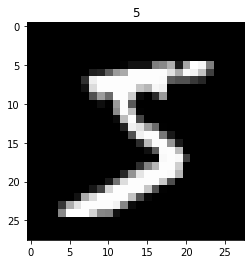

In [8]:
import matplotlib.pyplot as plt
plt.imshow(train_data.data[0], cmap='gray')
plt.title('%i' % train_data.targets[0])
plt.show()

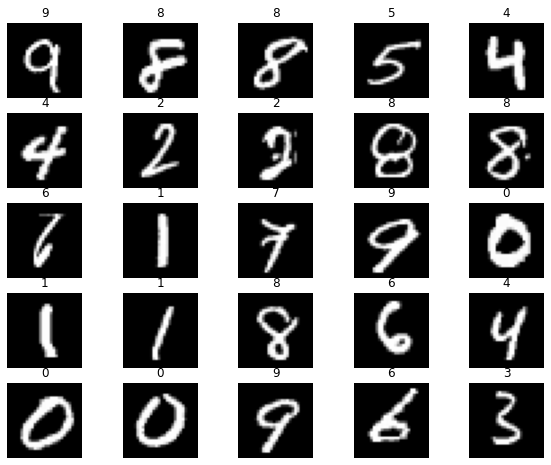

In [9]:
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

Preparando dados para treinamento com DataLoaders
Rotulando uma amostra por vez.

In [10]:
from torch.utils.data import DataLoader
loaders = {
    'train' : torch.utils.data.DataLoader(train_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
    
    'test'  : torch.utils.data.DataLoader(test_data, 
                                          batch_size=100, 
                                          shuffle=True, 
                                          num_workers=1),
}
loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f9bcaba2050>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f9bca4a0a50>}

Redes convolucional

Rede neural de convolução usando torch.nn.Module. torch.nn.Module será a classe base para todos os módulos de rede neural.

In [13]:
import torch.nn as nn
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2),    
        )
        self.conv2 = nn.Sequential(         
            nn.Conv2d(16, 32, 5, 1, 2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),                
        )
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # flatten the output of conv2 to (batch_size, 32 * 7 * 7)
        x = x.view(x.size(0), -1)       
        output = self.out(x)
        return output, x    # return x for visualization

saída

In [14]:
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [15]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

Definir uma função de otimização

In [16]:
from torch import optim
optimizer = optim.Adam(cnn.parameters(), lr = 0.01)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

Treinamento do modelo

função chamada train() e passe um número de épocas, modelos e carregadores de dados como parâmetros de entrada.

num_epochs: número de vezes que nosso modelo passará por todo o conjunto de dados de treinamento

In [23]:
from torch.autograd import Variable
num_epochs = 10
def train(num_epochs, cnn, loaders):
    
    cnn.train()
        
    # Train the model
    total_step = len(loaders['train'])
        
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(loaders['train']):
            
            # gives batch data, normalize x when iterate train_loader
            b_x = Variable(images)   # batch x
            b_y = Variable(labels)   # batch y
            output = cnn(b_x)[0]               
            loss = loss_func(output, b_y)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()                
            
            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))
               
        
        pass
    
    
    pass
train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/600], Loss: 0.1690
Epoch [1/10], Step [200/600], Loss: 0.0948
Epoch [1/10], Step [300/600], Loss: 0.0264
Epoch [1/10], Step [400/600], Loss: 0.0375
Epoch [1/10], Step [500/600], Loss: 0.0699
Epoch [1/10], Step [600/600], Loss: 0.0821
Epoch [2/10], Step [100/600], Loss: 0.0332
Epoch [2/10], Step [200/600], Loss: 0.0667
Epoch [2/10], Step [300/600], Loss: 0.0112
Epoch [2/10], Step [400/600], Loss: 0.0081
Epoch [2/10], Step [500/600], Loss: 0.0734
Epoch [2/10], Step [600/600], Loss: 0.0475
Epoch [3/10], Step [100/600], Loss: 0.0145
Epoch [3/10], Step [200/600], Loss: 0.0744
Epoch [3/10], Step [300/600], Loss: 0.0029
Epoch [3/10], Step [400/600], Loss: 0.0381
Epoch [3/10], Step [500/600], Loss: 0.1234
Epoch [3/10], Step [600/600], Loss: 0.0057
Epoch [4/10], Step [100/600], Loss: 0.0218
Epoch [4/10], Step [200/600], Loss: 0.1488
Epoch [4/10], Step [300/600], Loss: 0.0618
Epoch [4/10], Step [400/600], Loss: 0.0186
Epoch [4/10], Step [500/600], Loss: 0.0227
Epoch [4/10

Modelo nos dados de teste

chamar model.eval() para definir as camadas de eliminação e normalização de lote para o modo de avaliação antes de executar a inferência.

In [24]:
def test():
    # Test the model
    cnn.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in loaders['test']:
            test_output, last_layer = cnn(images)
            pred_y = torch.max(test_output, 1)[1].data.squeeze()
            accuracy = (pred_y == labels).sum().item() / float(labels.size(0))
            pass
            print('Test Accuracy of the model on the 10000 test images: %.2f' % accuracy)
    
    pass
test()

Test Accuracy of the model on the 10000 test images: 0.97
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 0.97
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.97
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.99
Test Accuracy of the model on the 10000 test images: 0.98
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy of the model on the 10000 test images: 1.00
Test Accuracy 

Imprima 10 previsões de dados de teste

In [25]:
sample = next(iter(loaders['test']))
imgs, lbls = sample

In [26]:
actual_number = lbls[:10].numpy()
actual_number

array([4, 0, 7, 3, 5, 2, 4, 4, 8, 9])

Resultado final

In [27]:
test_output, last_layer = cnn(imgs[:10])
pred_y = torch.max(test_output, 1)[1].data.numpy().squeeze()
print(f'Prediction number: {pred_y}')
print(f'Actual number: {actual_number}')

Prediction number: [4 0 7 3 5 2 4 4 8 9]
Actual number: [4 0 7 3 5 2 4 4 8 9]
